In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from IPython.display import display
import ipywidgets as widgets

In [ ]:
#Importing and inspecting the data

#Loaded the dataset
df=pd.read_csv("zomato.csv",encoding='latin-1')
print("Displaying the first 5 rows:",df.head())
print(" ")

print("Displaying the columns:",df.columns)
print(" ")
print("Displaying the datatypes:",df.info())
print(" ")

#Dropped duplicates
df.drop_duplicates(subset='Restaurant ID', inplace=True)
df=df[df['Cuisines'].notnull()]     #For NLP
df=df[df['Aggregate rating'] > 0]   #avoiding unrated

df.reset_index(drop=True, inplace=True)


Displaying the first 5 rows:    Restaurant ID         Restaurant Name  Country Code              City  \
0        6317637        Le Petit Souffle           162       Makati City   
1        6304287        Izakaya Kikufuji           162       Makati City   
2        6300002  Heat - Edsa Shangri-La           162  Mandaluyong City   
3        6318506                    Ooma           162  Mandaluyong City   
4        6314302             Sambo Kojin           162  Mandaluyong City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue, Legaspi...   
2  Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...   
3  Third Floor, Mega Fashion Hall, SM Megamall, O...   
4  Third Floor, Mega Atrium, SM Megamall, Ortigas...   

                                     Locality  \
0   Century City Mall, Poblacion, Makati City   
1  Little Tokyo, Legaspi Village, Makati City   
2  Edsa Shangri-La, Ortigas, M

In [7]:
#Checking missing values

missing=df.isnull().sum()

#Filters only the columns that has missing values
missing = missing[missing > 0].sort_values(ascending=False)

if not missing.empty:
    missing.plot(kind='barh', figsize=(10, 6), color='salmon')
    plt.title("Columns with Missing Data")
    plt.xlabel("Number of Missing Values")
    plt.show()

    print("Missing value summary:\n", missing)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


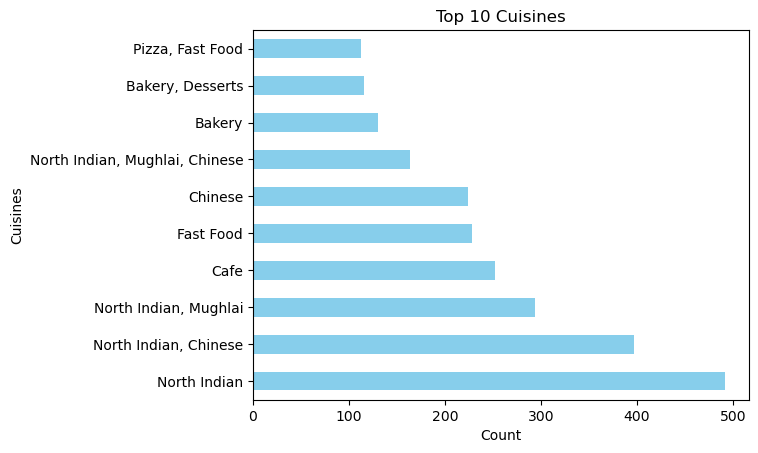


Word indexes:
{'french': 54, 'japanese': 73, 'desserts': 41, 'seafood': 118, 'asian': 6, 'filipino': 50, 'sushi': 130, 'korean': 79, 'chinese': 31, 'european': 48, 'indian': 66, 'mexican': 91, 'american': 2, 'ice': 65, 'cream': 36, 'cafe': 24, 'italian': 71, 'pizza': 108, 'bakery': 10, 'mediterranean': 89, 'fast': 49, 'food': 53, 'brazilian': 18, 'arabian': 4, 'bar': 11, 'grill': 60, 'international': 68, 'peruvian': 107, 'latin': 81, 'burger': 21, 'juices': 74, 'healthy': 63, 'beverages': 15, 'lebanese': 82, 'sandwich': 116, 'steak': 126, 'bbq': 12, 'gourmet': 58, 'north': 100, 'eastern': 47, 'coffee': 33, 'tea': 133, 'vegetarian': 139, 'tapas': 132, 'breakfast': 19, 'diner': 43, 'southern': 122, 'southwestern': 123, 'spanish': 124, 'argentine': 5, 'caribbean': 28, 'german': 56, 'vietnamese': 140, 'thai': 136, 'modern': 94, 'australian': 8, 'teriyaki': 134, 'cajun': 25, 'canadian': 26, 'tex': 135, 'mex': 90, 'middle': 92, 'greek': 59, 'fusion': 55, 'cuban': 37, 'hawaiian': 62, 'salad'

In [14]:
# Top cuisines
top_cuisines = df['Cuisines'].value_counts().head(10)
top_cuisines.plot(kind='barh', color='skyblue')
plt.title('Top 10 Cuisines')
plt.xlabel('Count')
plt.show()

# Normalize city names
df['City'] = df['City'].str.strip().str.title()

# Simplify cuisines (limit to top 3 in each row)
df['Cleaned_Cuisines'] = df['Cuisines'].apply(lambda x: ', '.join(x.split(',')[:3]))

# TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words='english')
result = tfidf.fit_transform(df['Cleaned_Cuisines'])

# Similarity matrix
cosine_sim = cosine_similarity(result, result)

print('\nWord indexes:')
print(tfidf.vocabulary_)
print('\ntf-idf values:')
for word, idf_val in zip(tfidf.get_feature_names_out(), tfidf.idf_):
    print(word, ':', idf_val)
print(result)
print('\ntf-idf values in matrix form:')
print(result.toarray())

print("Cosine Similarity Matrix:")
print(cosine_sim)

In [27]:
df['Restaurant Name'].to_frame().style.set_table_attributes('style="height:300px; overflow-y:scroll; display:block;"')

,Restaurant Name
0,Le Petit Souffle
1,Izakaya Kikufuji
2,Heat - Edsa Shangri-La
3,Ooma
4,Sambo Kojin
5,Din Tai Fung
6,Buffet 101
7,Vikings
8,Spiral - Sofitel Philippine Plaza Manila
9,Locavore


In [51]:
print("Top 50 based on highest rating:\n")
top_50 = df.sort_values('Aggregate rating', ascending=False).head(50)
print(top_50[['Restaurant Name', 'Aggregate rating']])
print(' \n')

print("Top 10 based on number of votes:\n")
top_5_votes = df.sort_values('Votes', ascending=False).head(10)
print(top_5_votes[['Restaurant Name', 'Votes']])

Top 50 based on highest rating:

                                 Restaurant Name  Aggregate rating
620                              Sheroes Hangout               4.9
573                          Carnival By Tresind               4.9
1954                   AB's - Absolute Barbecues               4.9
2062                             Barbeque Nation               4.9
38                                    Coco Bambu               4.9
7357                            Ministry of Crab               4.9
7267                   Mainland China Restaurant               4.9
2067                             Barbeque Nation               4.9
2071                   Grandson of Tunday Kababi               4.9
240                                     The Cafe               4.9
1942                             Barbeque Nation               4.9
47                            Braseiro da Gíçvea               4.9
227                          Tantra Asian Bistro               4.9
49                           

In [98]:
# Build indices: map restaurant names (lowercase) to their index
indices = pd.Series(df.index, index=df['Restaurant Name'].str.lower()).drop_duplicates()

# Recommend function
def recommend_restaurant(name, top_n=5):
    # Convert user input to lowercase
    name = name.strip().lower()  
    
    # Get index of the restaurant
    idx = indices[name]
    
    # Get similarity scores for all restaurants
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort restaurants based on similarity scores (highest first)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    # Get the indices of the most similar restaurants
    restaurant_indices = [i[0] for i in sim_scores]
    
    # Fetch and return recommended restaurants
    recommendations = df.iloc[restaurant_indices][['Restaurant Name', 'City', 'Cleaned_Cuisines', 'Aggregate rating', 'Votes']]
    return recommendations.reset_index(drop=True)

print("Recommendations based on top voting:")
print("Toit")
recommend_1=recommend_restaurant("Toit") 
display(recommend_1)
print("Hauz Khas Social")
recommend_2=recommend_restaurant("Hauz Khas Social")
display(recommend_2)
print("Peter Cat")
recommend_3=recommend_restaurant("Peter Cat")
display(recommend_3)
print("Big Brewsky")
recommend_4=recommend_restaurant("Big Brewsky")
display(recommend_4)
print("The Black Pearl")
recommend_5=recommend_restaurant("The Black Pearl")
display(recommend_5)

Recommendations based on top voting:
Toit


,Restaurant Name,City,Cleaned_Cuisines,Aggregate rating,Votes
0,DePalma's Italian Cafe - East Side,Athens,"American, Italian, Pizza",4.1,387
1,Monica's,Cedar Rapids/Iowa City,"American, Italian, Pizza",3.8,161
2,Toit,Bangalore,"Italian, American, Pizza",4.8,10934
3,Portneuf Valley Brewing,Pocatello,"American, Pizza",3.7,191
4,Nonna's Pasta & Pizzeria,Santa Rosa,"Italian, Pizza",4.0,72


Hauz Khas Social


,Restaurant Name,City,Cleaned_Cuisines,Aggregate rating,Votes
0,Odeon Social,New Delhi,"Continental, American, Asian",4.1,1959
1,Def Col Social,New Delhi,"Continental, American, Asian",3.9,798
2,Hauz Khas Social,New Delhi,"Continental, American, Asian",4.3,7931
3,Eram Rooftop,Bhubaneshwar,"Asian, Continental",3.5,89
4,Dock Forty Five,Hyderabad,"Continental, Asian",4.2,79


Peter Cat


,Restaurant Name,City,Cleaned_Cuisines,Aggregate rating,Votes
0,Tim's Bistro,Coimbatore,"North Indian, Continental",3.9,85
1,Knight Rider,Gurgaon,"North Indian, Continental",3.1,185
2,The Breakfast Club,Gurgaon,"Continental, North Indian",3.5,189
3,Outback,Gurgaon,"Continental, North Indian",3.4,106
4,Spices & Sauces,Gurgaon,"North Indian, Continental",3.0,8


Big Brewsky


,Restaurant Name,City,Cleaned_Cuisines,Aggregate rating,Votes
0,Uptown Fresh Beer Cafe,Gurgaon,"Finger Food, North Indian, Italian",4.1,230
1,Spindrift,Mangalore,"North Indian, Italian, Finger Food",3.9,156
2,The Beer Cafe - BIGGIE,New Delhi,"Finger Food, North Indian, Italian",3.8,645
3,Qash Retro Bar,New Delhi,"Finger Food, North Indian, Italian",2.7,81
4,The Beer Cafe,New Delhi,"Finger Food, North Indian, Italian",3.5,295


The Black Pearl


,Restaurant Name,City,Cleaned_Cuisines,Aggregate rating,Votes
0,AB's - Absolute Barbecues,Bangalore,"European, Mediterranean, North Indian",4.6,6907
1,AB's - Absolute Barbecues,Chennai,"North Indian, European, Mediterranean",4.9,859
2,Barbeque Nation,Coimbatore,"North Indian, European, Mediterranean",4.4,505
3,Latitude - Vivanta By Taj,Gurgaon,"North Indian, Mediterranean, European",3.8,305
4,AB's - Absolute Barbecues,Hyderabad,"European, Mediterranean, North Indian",4.9,200


In [86]:
# Build indices: map restaurant names (lowercase) to their index
indices = pd.Series(df.index, index=df['Restaurant Name'].str.lower()).drop_duplicates()

# Recommend function
def recommend_restaurant(name, top_n=5):
    # Convert user input to lowercase
    name = name.strip().lower()  
    
    # Check if restaurant exists
    if name not in indices.index: 
        print(f"Restaurant '{name}' not found! Please check the spelling.")
        return None
    
    # Get index of the restaurant
    idx = indices[name]
    
    # Get similarity scores for all restaurants
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort restaurants based on similarity scores (highest first)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    # Get the indices of the most similar restaurants
    restaurant_indices = [i[0] for i in sim_scores]
    
    # Fetch and return recommended restaurants
    recommendations = df.iloc[restaurant_indices][['Restaurant Name', 'City', 'Cleaned_Cuisines', 'Aggregate rating', 'Votes']]
    return recommendations.reset_index(drop=True)

# Example call:
recommend_restaurant("Hauz Khas Social") 

,Restaurant Name,City,Cleaned_Cuisines,Aggregate rating,Votes
0,Odeon Social,New Delhi,"Continental, American, Asian",4.1,1959
1,Def Col Social,New Delhi,"Continental, American, Asian",3.9,798
2,Hauz Khas Social,New Delhi,"Continental, American, Asian",4.3,7931
3,Eram Rooftop,Bhubaneshwar,"Asian, Continental",3.5,89
4,Dock Forty Five,Hyderabad,"Continental, Asian",4.2,79


In [114]:
# Must be defined earlier in the notebook
def recommend_filtered(name, city=None, online_delivery=None):
    name = name.lower()
    if name not in indices:
        print("Restaurant not found!")
        return pd.DataFrame()
    
    idx = indices[name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:]
    
    filtered = df.iloc[[i[0] for i in sim_scores]]
    
    if city:
        filtered = filtered[filtered['City'].str.lower() == city.lower()]
    if online_delivery is not None:
        filtered = filtered[filtered['Has Online delivery'] == online_delivery]
    
    if filtered.empty:
        print("No matching restaurants found after filtering.")
        return pd.DataFrame()
    
    return filtered[['Restaurant Name', 'City', 'Cleaned_Cuisines', 'Aggregate rating', 'Has Online delivery']].head(5).reset_index(drop=True)


# 1. Restaurant Selector
restaurant_selector = widgets.Dropdown(
    options=sorted(df['Restaurant Name'].dropna().unique().tolist()),
    description='Restaurant:',
    layout={'width': '400px'},
    style={'description_width': 'initial'}
)

# 2. City Selector
city_selector = widgets.Dropdown(
    options=['Any'] + sorted(df['City'].dropna().unique().tolist()),  # 'Any' = no filter
    description='City:',
    layout={'width': '300px'},
    style={'description_width': 'initial'}
)

# 3. Recommend Button
recommend_button = widgets.Button(
    description='Recommend',
    button_style='success',  # 'success', 'info', 'warning', 'danger'
    tooltip='Click to get recommendations',
    layout={'width': '150px'}
)

# 4. Output area
output = widgets.Output()

# 5. Recommendation function
def on_recommend_clicked(b):
    with output:
        output.clear_output()
        selected_restaurant = restaurant_selector.value
        selected_city = city_selector.value
        
        if selected_city == 'Any':
            city_filter = None
        else:
            city_filter = selected_city
        
        recommendations = recommend_filtered(selected_restaurant, city=city_filter, online_delivery=None)
        
        if not recommendations.empty:
            display(recommendations)
        else:
            print("No recommendations found.")

# 6. Attach button
recommend_button.on_click(on_recommend_clicked)

# 7. Display all widgets together
display(widgets.VBox([restaurant_selector, city_selector, recommend_button, output]))


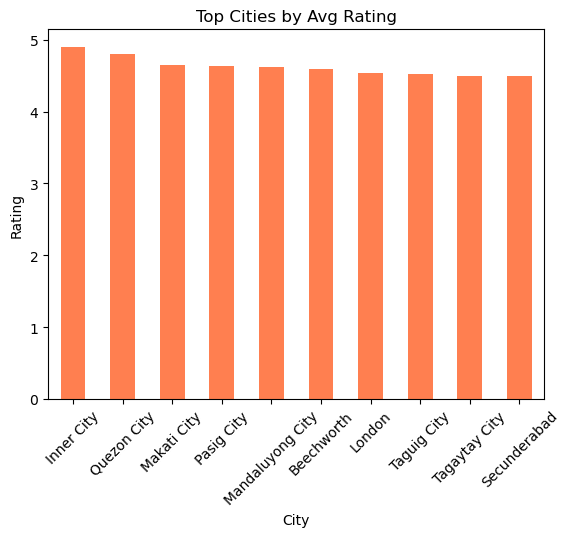

In [115]:
top_cities = df.groupby('City')['Aggregate rating'].mean().sort_values(ascending=False).head(10)
top_cities.plot(kind='bar', color='coral')
plt.title("Top Cities by Avg Rating")
plt.ylabel("Rating")
plt.xticks(rotation=45)
plt.show()

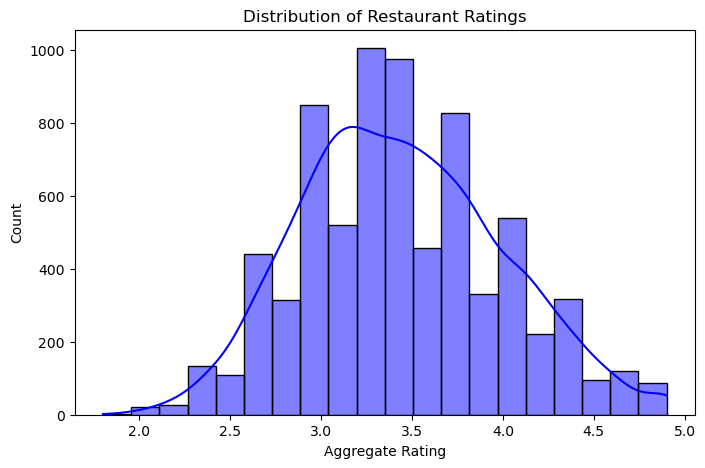

In [118]:
plt.figure(figsize=(8,5))
sns.histplot(df['Aggregate rating'], bins=20, kde=True, color='blue')
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Aggregate Rating')
plt.ylabel('Count')
plt.show()

C:\Users\asoun\AppData\Local\Temp\ipykernel_24804\3683654837.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cuisine_counts.index, y=cuisine_counts.values, palette='viridis')


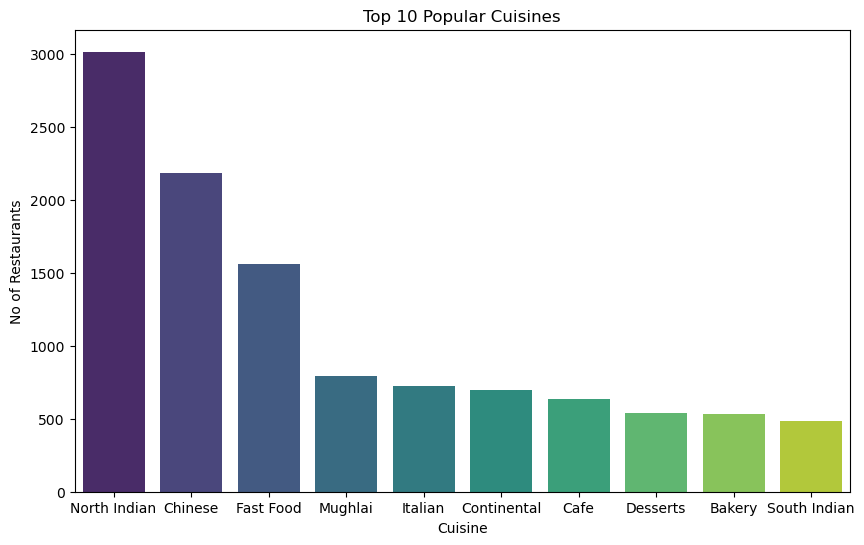

In [123]:
# Split cuisines and count
cuisine_counts = df['Cuisines'].str.split(', ').explode().value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=cuisine_counts.index, y=cuisine_counts.values, palette='viridis')
plt.title('Top 10 Popular Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('No of Restaurants')
plt.show()

C:\Users\asoun\AppData\Local\Temp\ipykernel_24804\2296729574.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_counts.index, y=city_counts.values, palette='magma')


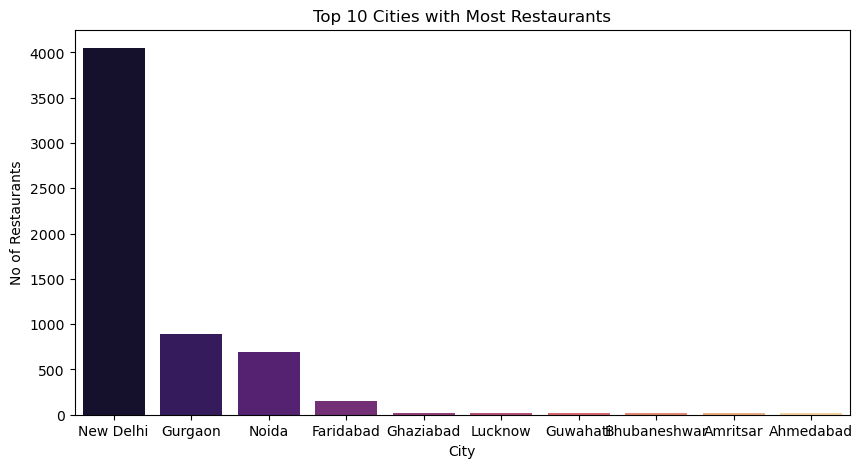

In [124]:
city_counts = df['City'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=city_counts.index, y=city_counts.values, palette='magma')
plt.title('Top 10 Cities with Most Restaurants')
plt.xlabel('City')
plt.ylabel('No of Restaurants')
plt.show()

C:\Users\asoun\AppData\Local\Temp\ipykernel_24804\936312624.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Price range', data=df, palette='coolwarm')


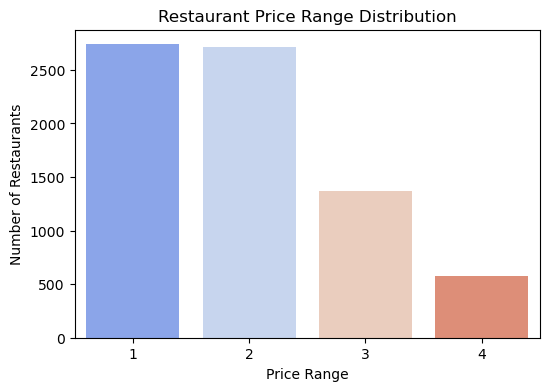

In [125]:
plt.figure(figsize=(6,4))
sns.countplot(x='Price range', data=df, palette='coolwarm')
plt.title('Restaurant Price Range Distribution')
plt.xlabel('Price Range')
plt.ylabel('Number of Restaurants')
plt.show()

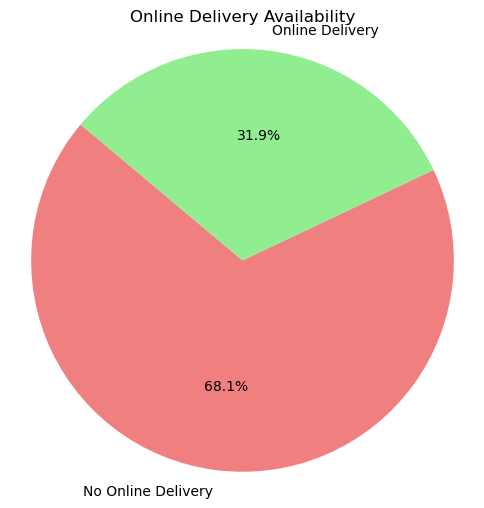

In [127]:
labels = ['No Online Delivery', 'Online Delivery']
sizes = df['Has Online delivery'].value_counts()
colors = ['lightcoral', 'lightgreen']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Online Delivery Availability')
plt.axis('equal')
plt.show()

C:\Users\asoun\AppData\Local\Temp\ipykernel_24804\2123520948.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating color', data=df, order=df['Rating color'].value_counts().index, palette='Set3')


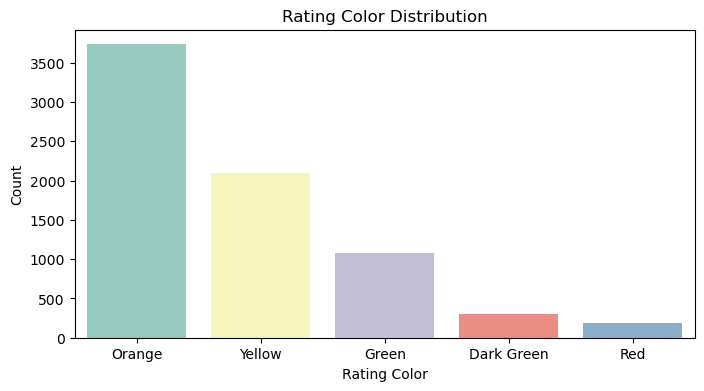

In [130]:
plt.figure(figsize=(8,4))
sns.countplot(x='Rating color', data=df, order=df['Rating color'].value_counts().index, palette='Set3')
plt.title('Rating Color Distribution')
plt.xlabel('Rating Color')
plt.ylabel('Count')
plt.show()

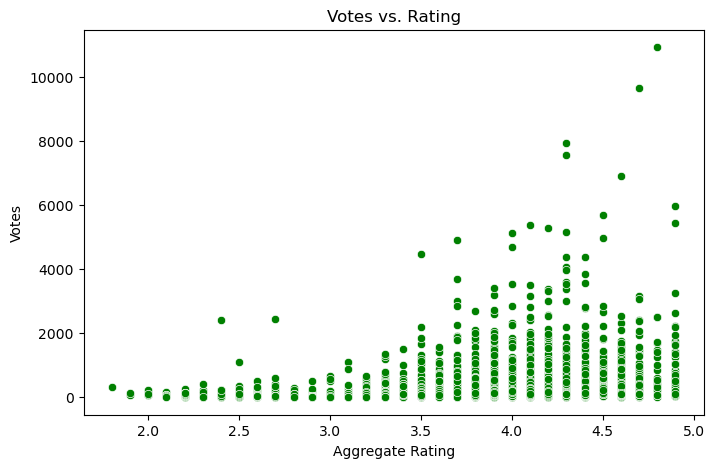

In [132]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Aggregate rating', y='Votes', data=df, color='green')
plt.title('Votes vs. Rating')
plt.xlabel('Aggregate Rating')
plt.ylabel('Votes')
plt.show()

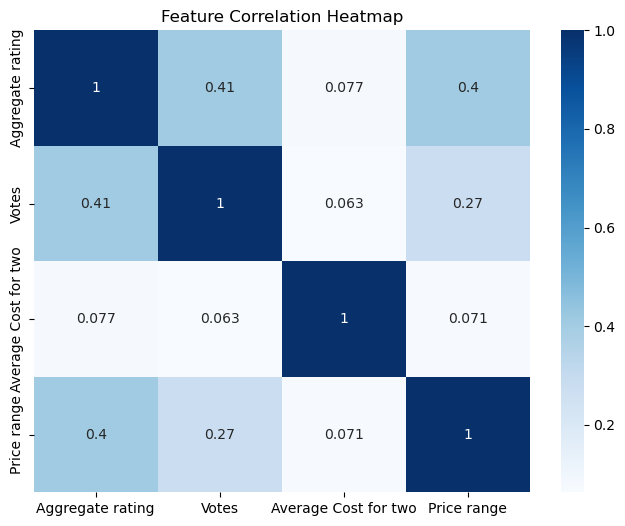

In [133]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['Aggregate rating', 'Votes', 'Average Cost for two', 'Price range']].corr(), annot=True, cmap='Blues')
plt.title('Feature Correlation Heatmap')
plt.show()